In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import GPy
sys.path.append("..")


In [10]:
WIN = 'D:/'
MAC = '/Volumes/zotero/17_20_PhD/19_20_PhD_Metabolomics/'

osp = MAC

### GP sampling 

Define several kernels from GPy.

In [4]:
import GPy
k_lin = GPy.kern.Linear(1)
k_exp = GPy.kern.Exponential(1)

k_rbf = GPy.kern.RBF(input_dim=1, variance=2.25, lengthscale=1.5)
k_mat32 = GPy.kern.Matern32(input_dim=1, variance=2., lengthscale=0.2)
k_mat52 = GPy.kern.Matern52(1)

k_per = GPy.kern.StdPeriodic(1, period=3.)
k_cos = GPy.kern.Cosine(1)
k_brwn = GPy.kern.Brownian(1)
k_nn = GPy.kern.MLP(1)

Make a vector with various kernels and calculate composite kernel.

In [6]:
ks = [k_lin, k_exp, k_rbf, k_nn, k_cos, k_rbf+k_nn, k_rbf*k_nn, k_rbf+k_cos]
ks_names = ['Linear', 'Exponential', 'RBF', 'MLP', 'Cosine', 'RBF+MLP', 'RBF*MLP','RBF+Cosine']

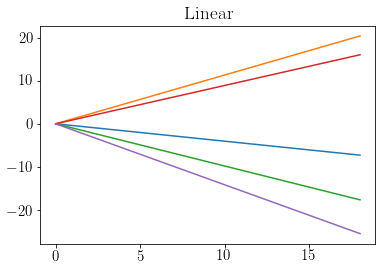

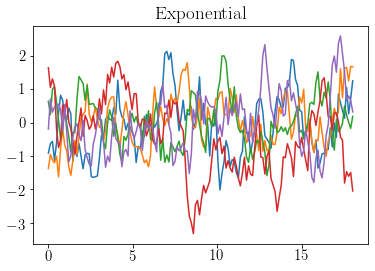

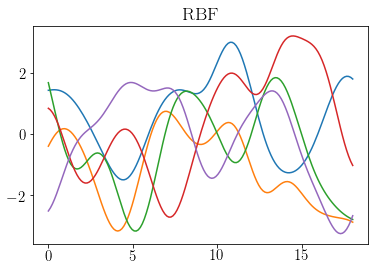

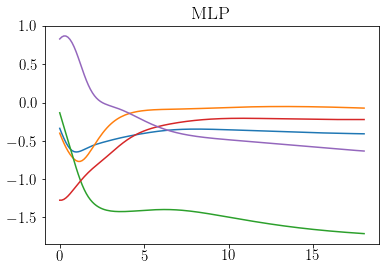

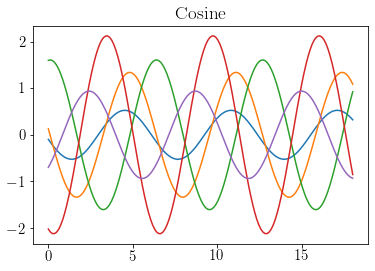

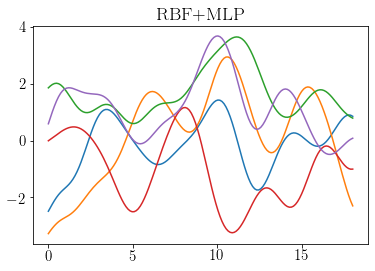

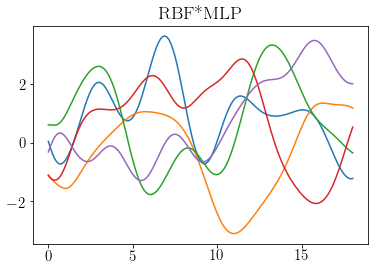

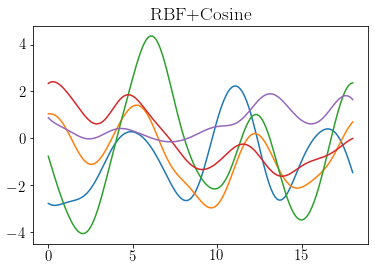

In [7]:
nice_fonts = {"text.usetex": True,
        "font.family": "serif",
        "font.serif" : "Times New Roman"}
plt.rcParams.update(nice_fonts)

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
for k, name in zip(ks,ks_names):
    fig, ax = plt.subplots(1,1)
    #sample from the kernel
    sample_space = np.linspace(0,18,150)[:,None]
    mu = np.zeros((150))
    C = k.K(sample_space)
        
    # Sample 5 times from a multivariate Gaussian distribution with mean 0 and covariance k(X,X)
    Z  = np.random.multivariate_normal(mu, C, 5)
    for i in range(5):
        plt.plot(sample_space, Z[i])
    plt.title(name, fontsize = 19)
    fig.savefig('/Users/anamaria/Desktop/thesis_pictures/'+name+'.png', format='png', dpi =400, bbox_inches='tight')
    plt.show()

### GP regression for the RTs

Load the dictionary of matching standards.

In [11]:
with open(osp+'positive_mode/standards.dict', 'rb') as file:
    matches = pickle.load(file)

In [9]:
with open(osp+'pymz/mzmine/std_matches.txt', 'rb') as file:
    matches = pickle.load(file)


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/pymz/mzmine/std_matches.txt'

In [4]:
with open(osp+'pymz/mzmine/std_matches_3ppm.txt', 'rb') as file:
    matches = pickle.load(file)


In [19]:
with open(osp+'pymz/mzmine/std_matches_toxid.txt', 'rb') as file:
    matches_toxid = pickle.load(file)

In [5]:
matches

{'serotonin': {'Mal_Std1_1_20Dec16': (1.0, 177.10236, 4.02, 314135.0),
  'Tryps_stds1_2_24May16': (1.0, 177.10229, 4.3, 1915.0),
  'Hat_Std1_2_20150130': (2.0, 177.10223, 12.53, 15993618.0),
  'Hat_Std1_1_20150130': (2.0, 177.10222, 12.46, 18218192.0)},
 'melatonin': {'Mal_Std1_1_20Dec16': (2.0, 233.12828, 4.32, 1729600988.0),
  'Mal_Std1_2_20Dec16': (1.0, 233.12817, 4.3, 1786176528.0),
  'VL_Std1_1_06Mar18': (1.0, 233.1282, 4.25, 1271105472.0),
  'VL_Std1_2_06Mar18': (1.0, 233.12825, 4.29, 1036508880.0),
  'Zik_Std1_1_23Oct18': (1.0, 233.12831, 4.09, 2046167614.0),
  'Zik_Std1_2_23Oct18': (1.0, 233.12837, 4.05, 2130536061.0),
  'Tryps_stds1_2_24May16': (2.0, 233.12813, 4.53, 39585416.0),
  'Hat_Std1_2_20150130': (3.0, 233.12825, 5.98, 174812747.0),
  'Hat_Std1_1_20150130': (3.0, 233.12825, 5.98, 235811275.0)},
 'phenylhydrazine': {'Mal_Std1_1_20Dec16': (3.0, 109.07604, 4.86, 6144530.0),
  'Mal_Std1_2_20Dec16': (2.0, 109.07597, 4.8, 6329873.0),
  'VL_Std1_1_06Mar18': (2.0, 109.07605, 4

In [11]:
mal_1_mz

[233.12813,
 109.07611,
 124.03925,
 170.08073,
 377.14508,
 136.06165,
 114.06614,
 166.08614,
 132.10197,
 138.05499,
 269.08771,
 152.07042,
 192.00867,
 150.05818,
 127.05016,
 205.09685,
 222.09705,
 244.09258,
 152.05666,
 118.08627,
 116.07057,
 258.10974,
 120.06562,
 132.06549,
 189.12315,
 180.08656,
 147.0762,
 126.02197,
 134.0448,
 133.0607,
 90.05508,
 76.03945,
 106.04996,
 142.02632,
 176.10287,
 191.10254,
 147.11276,
 175.11887,
 167.03839,
 298.0965,
 123.05526,
 154.09738,
 168.06528,
 150.07729,
 252.1086,
 220.11757,
 124.03925,
 127.05022,
 268.1037,
 137.04578,
 130.04991,
 239.1057,
 209.09193,
 118.0862,
 112.0505,
 132.10184,
 136.04251,
 147.07643,
 284.09808,
 332.07504,
 102.05505,
 170.09227,
 162.11205,
 183.09344,
 182.08061,
 146.11713,
 348.06989,
 133.06055,
 90.05505,
 184.07304,
 308.0632,
 162.07599,
 120.06551,
 175.1076,
 104.07063,
 223.07455,
 104.10695,
 76.07581,
 133.09718,
 206.06657,
 102.05502,
 124.03927,
 204.12259,
 148.06041,
 132.06

In [6]:
def create_bins_mz_range(dataset, n_bins):
    dataset.sort()
    lowest_value = np.min(dataset)-0.001
    highest_value = np.max(dataset)+0.001
    width = (highest_value - lowest_value)/n_bins
    bins = []
    for i in range(n_bins):
        bins.append((lowest_value+width*i, lowest_value+width*(i+1)))
    nb = [i[0] for i in bins]
    nb.append(bins[-1][1])
    return nb

def return_stratcol(rt, mz, ref_rt, ref_mz, nbins):
    df = pd.DataFrame([rt, mz, ref_rt, ref_mz, np.subtract(ref_rt, rt)]).transpose()
    df.columns = ['rt', 'mz', 'ref_rt', 'ref_mz', 'drift']

    #check correlations between columns
    corr_matrix = df.corr()
    colname = corr_matrix['drift'].sort_values(ascending=False).index[1]
    
    bins = create_bins_mz_range(list(df[colname]), nbins)
    
    df['rt_cat'] = pd.cut(df[colname], 
                              bins=bins,
                              labels=np.arange(1,nbins+1,1))
    return df['rt_cat']

In [6]:
stratcol['drift'].sort_values(ascending=False).index[1]

NameError: name 'stratcol' is not defined

In [7]:
stratcol = return_stratcol(mal_1_rt, mal_1_mz, zik_1_rt, zik_1_mz, nbins = 5)

NameError: name 'mal_1_rt' is not defined

In [8]:
from metab_utils import get_rts_between_datasets
mal_1_rt, mal_1_mz, zik_1_rt, zik_1_mz = get_rts_between_datasets('tryps', 'zik', matches_toxid, replicate=2)



stratcol = return_stratcol(mal_1_rt, mal_1_mz, zik_1_rt, zik_1_mz, nbins = 5)
output_dir = osp+'positive_mode/'
from gpr_utils import get_drift_gpr_model
mtryps, accuracy, mae, mse = get_drift_gpr_model(zik_1_rt, mal_1_rt, stratcol, output_dir,zscore = 2, plot = True)

NameError: name 'matches_toxid' is not defined

[1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 1, 1, 1, 2, 2, 2, 2, 3]
Choosing the optimal kernel
Optimization restart 1/10, f = 20.089460870618186
Optimization restart 2/10, f = 20.089460870607375
Optimization restart 3/10, f = 20.08946087135362
Optimization restart 4/10, f = 20.08946087097028
Optimization restart 5/10, f = 20.089460870614595
Optimization restart 6/10, f = 20.08946087061716
Optimization restart 7/10, f = 20.089460870613422
Optimization restart 8/10, f = 20.089460870850775
Optimization restart 9/10, f = 20.089460879877898
Optimization restart 10/10, f = 20.08946087070777


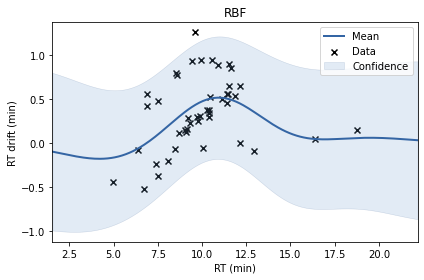

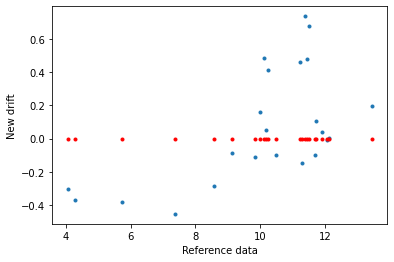

Cross-Predicted Accuracy for RBF : 0.9803909414114425
Mean absolute error for RBF : 0.26818805301175336
Mean squared error for RBF : 0.11591838507740496
Optimization restart 1/10, f = 21.501066273240735
Optimization restart 2/10, f = 21.501066273713345
Optimization restart 3/10, f = 21.50106627517685
Optimization restart 4/10, f = 21.501066311399946
Optimization restart 5/10, f = 21.50106627291431
Optimization restart 6/10, f = 21.501066274006032
Optimization restart 7/10, f = 21.501066272831945
Optimization restart 8/10, f = 21.501066272798937
Optimization restart 9/10, f = 21.501066272804373
Optimization restart 10/10, f = 21.50106627463383


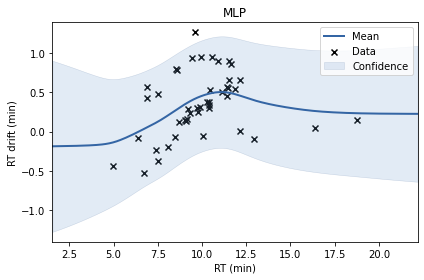

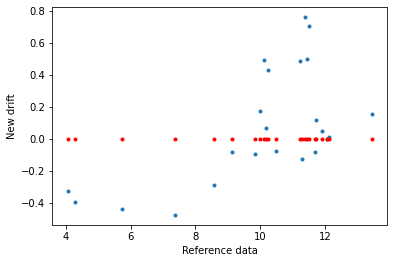

Cross-Predicted Accuracy for MLP : 0.978886435758407
Mean absolute error for MLP : 0.2758099075181604
Mean squared error for MLP : 0.12481222691341552
Optimization restart 1/10, f = 20.08946179567859
Optimization restart 2/10, f = 20.08946578730378
Optimization restart 3/10, f = 20.08946129588227
Optimization restart 4/10, f = 21.50106627306819
Optimization restart 5/10, f = 20.08946091993176
Optimization restart 6/10, f = 21.501066272800625
Optimization restart 7/10, f = 20.089460907381543
Optimization restart 8/10, f = 20.08946207850784
Optimization restart 9/10, f = 20.08946355355706
Optimization restart 10/10, f = 20.08946127040792


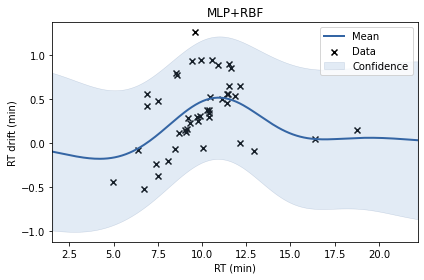

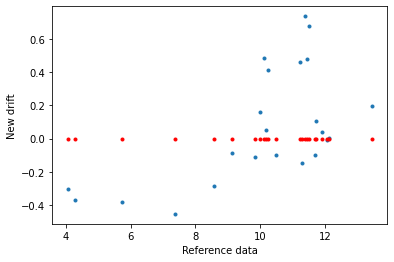

Cross-Predicted Accuracy for MLP+RBF : 0.9803909467789184
Mean absolute error for MLP+RBF : 0.2681881742931619
Mean squared error for MLP+RBF : 0.11591835334772575
Optimization restart 1/10, f = 20.075318295791263
Optimization restart 2/10, f = 20.075182700482937
Optimization restart 3/10, f = 20.075182842850328
Optimization restart 4/10, f = 20.075183740981927
Optimization restart 5/10, f = 20.075219388667257
Optimization restart 6/10, f = 20.075182667916433
Optimization restart 7/10, f = 20.07518267094374
Optimization restart 8/10, f = 20.07518277008462
Optimization restart 9/10, f = 20.075182860869326
Optimization restart 10/10, f = 20.07518277366582


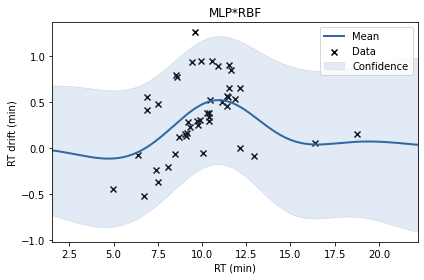

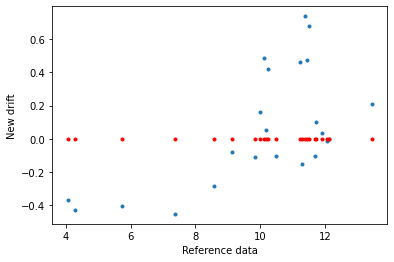

Cross-Predicted Accuracy for MLP*RBF : 0.9797113214012863
Mean absolute error for MLP*RBF : 0.2738150084622402
Mean squared error for MLP*RBF : 0.11993593919341741
Final kernel: RBF
Optimization restart 1/10, f = 26.734548380706244
Optimization restart 2/10, f = 26.73454838041848
Optimization restart 3/10, f = 26.734548380434333
Optimization restart 4/10, f = 26.734548380417145
Optimization restart 5/10, f = 26.734548380412747
Optimization restart 6/10, f = 26.734548380415767
Optimization restart 7/10, f = 26.734548380440614
Optimization restart 8/10, f = 26.734548380546265
Optimization restart 9/10, f = 26.734548380412548
Optimization restart 10/10, f = 26.73454838041792


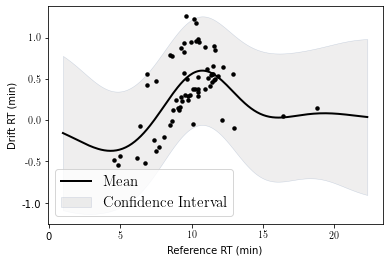


Name : GP regression
Objective : 26.734548380412548
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   0.1364662034944715  |      +ve      |        
  rbf.lengthscale          |    2.688002772388335  |      +ve      |        
  Gaussian_noise.variance  |  0.10950492191490073  |      +ve      |        


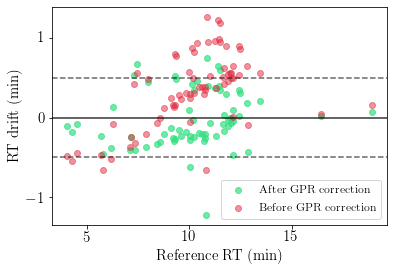

In [9]:
from metab_utils import get_rts_between_datasets
mal_1_rt, mal_1_mz, zik_1_rt, zik_1_mz = get_rts_between_datasets('tryps', 'zik', matches, replicate=2)



stratcol = return_stratcol(mal_1_rt, mal_1_mz, zik_1_rt, zik_1_mz, nbins = 4)
output_dir = osp+'positive_mode/tryps/'
from gpr_utils import get_drift_gpr_model
mtryps, accuracy, mae, mse = get_drift_gpr_model(zik_1_rt, mal_1_rt, stratcol, output_dir,zscore = 2, plot = True)

In [100]:
print(accuracy, mae, mse)

0.9805172101553806 0.2833393887749292 0.1238094644721248


In [37]:
with open(osp+'positive_mode/mtryps.txt', 'wb') as handle:
    pickle.dump(mtryps, handle)

#### Zika RT vs Malaria RT

In [8]:
from metab_utils import get_rts_between_datasets
mal_1_rt, zik_1_rt, mal1_zik1_diff = get_rts_between_datasets('mal', 'zik', matches)

NameError: name 'matches' is not defined

In [12]:
from metab_utils import get_rts_between_datasets
mal_1_rt, mal_1_mz, zik_1_rt, zik_1_mz, mal1_zik1_diff = get_rts_between_datasets('mal', 'zik', matches)

df = pd.DataFrame([mal_1_rt, mal_1_mz, zik_1_rt, zik_1_mz, mal1_zik1_diff]).transpose()
df.columns = ['Mal rt', 'Mal mz', 'ZIK rt', 'ZIK mz', 'drift']

#check correlations between columns
corr_matrix = df.corr()
corr_matrix['drift'].sort_values(ascending=False)

df['Mal rt'].hist()
df['mal_rt_cat'] = pd.cut(df['Mal rt'], 
                          bins=[3., 8., 12., 14, np.inf],
                          labels=[1, 2, 3, 4])

ValueError: not enough values to unpack (expected 5, got 4)

In [14]:
from metab_utils import plot_and_get_values_for_regression
zik_1_rt_mod, mal_1_rt_mod = plot_and_get_values_for_regression(zik_1_rt,'Zik',mal_1_rt,'Malaria',  mal1_zik1_diff, ml = False, zscore = 1.4)

NameError: name 'zik_1_rt' is not defined

Trying different type of kernels for the GP regression. At the end, the one with the highest cross-predicted accuracy is displayed.

In [13]:
from metab_utils import try_gp_regressions
mmal, kmal, resultsmal = try_gp_regressions(mal_1_rt_mod, zik_1_rt_mod-mal_1_rt_mod)

NameError: name 'mal_1_rt_mod' is not defined

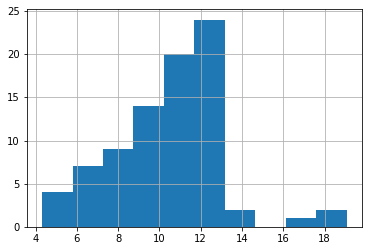

In [16]:
df['Mal rt'].hist()

In [18]:
df['Mal rt'].hist()
df['mal_rt_cat'] = pd.cut(df['Mal rt'], 
                          bins=[3., 8., 12., 14, np.inf],
                          labels=[1, 2, 3, 4])

In [16]:
def create_bins_mz_range(dataset, n_bins):
    dataset.sort()
    lowest_value = np.min(dataset)-0.001
    highest_value = np.max(dataset)+0.001
    width = (highest_value - lowest_value)/n_bins
    bins = []
    for i in range(n_bins):
        bins.append((lowest_value+width*i, lowest_value+width*(i+1)))
    nb = [i[0] for i in bins]
    nb.append(bins[-1][1])
    return nb

In [9]:
from metab_utils import get_rts_between_datasets
mal_1_rt, mal_1_mz, zik_1_rt, zik_1_mz = get_rts_between_datasets('mal', 'zik', matches)


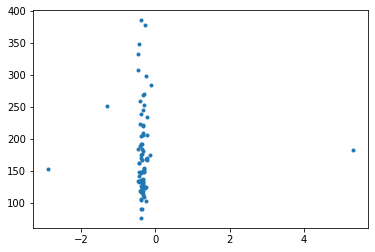

In [12]:
plt.plot(np.subtract(zik_1_rt, mal_1_rt), zik_1_mz, '.')

[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 3, 4, 1, 1, 1, 2, 2, 2, 2]
Choosing the optimal kernel
Optimization restart 1/10, f = -25.747742902939656
Optimization restart 2/10, f = -25.74774290709408
Optimization restart 3/10, f = -25.747742898694614
Optimization restart 4/10, f = -25.747742890363693
Optimization restart 5/10, f = -25.747742906956926
Optimization restart 6/10, f = -25.747742904084408
Optimization restart 7/10, f = -25.74774290681299
Optimization restart 8/10, f = -25.747742866278333
Optimization restart 9/10, f = -25.747742841655565
Optimization restart 10/10, f = -25.74774290690851


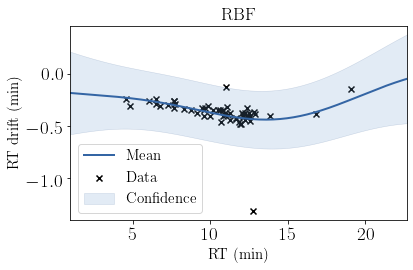

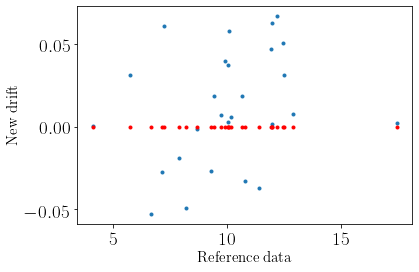

Cross-Predicted Accuracy for RBF : 0.9998072135423975
Mean absolute error for RBF : 0.029641006029671943
Mean squared error for RBF : 0.001325079095230135
Optimization restart 1/10, f = -25.72717398890801
Optimization restart 2/10, f = -25.727173999331704
Optimization restart 3/10, f = -25.543251204057377
Optimization restart 4/10, f = -25.543263802979435
Optimization restart 5/10, f = -25.543263394391477
Optimization restart 6/10, f = -25.54326369994074
Optimization restart 7/10, f = -25.543263820934367
Optimization restart 8/10, f = -25.727173998787276
Optimization restart 9/10, f = -25.543263839820757
Optimization restart 10/10, f = -25.543263765110627


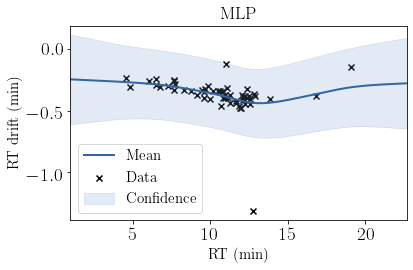

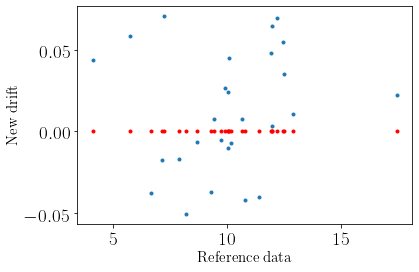

Cross-Predicted Accuracy for MLP : 0.9997857325723577
Mean absolute error for MLP : 0.03211463834780869
Mean squared error for MLP : 0.0014727242394955997
Optimization restart 1/10, f = -26.191945069912297
Optimization restart 2/10, f = -26.191943741485357
Optimization restart 3/10, f = -26.191941823119084
Optimization restart 4/10, f = -26.191945414444376
Optimization restart 5/10, f = -26.191945436162708
Optimization restart 6/10, f = -26.19193882417846
Optimization restart 7/10, f = -26.191940197841134
Optimization restart 8/10, f = -26.191938083076355
Optimization restart 9/10, f = -26.191945438742223
Optimization restart 10/10, f = -26.19193853997168


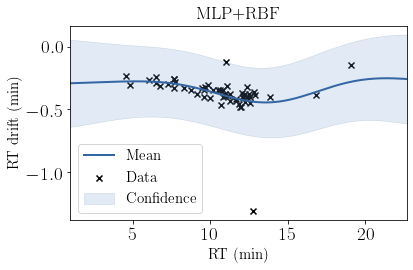

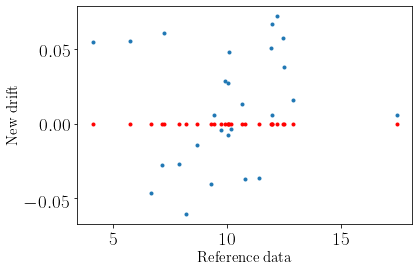

Cross-Predicted Accuracy for MLP+RBF : 0.9997675423528641
Mean absolute error for MLP+RBF : 0.03376852238375957
Mean squared error for MLP+RBF : 0.0015977510691203725
Optimization restart 1/10, f = -25.749131157086513
Optimization restart 2/10, f = -25.749240717681936
Optimization restart 3/10, f = -25.749257530333864
Optimization restart 4/10, f = -25.749319778978077
Optimization restart 5/10, f = -25.749150647219363
Optimization restart 6/10, f = -25.749182829112417
Optimization restart 7/10, f = -25.749478718141834
Optimization restart 8/10, f = -25.74947900090107
Optimization restart 9/10, f = -25.749299019434385
Optimization restart 10/10, f = -25.749478966821883


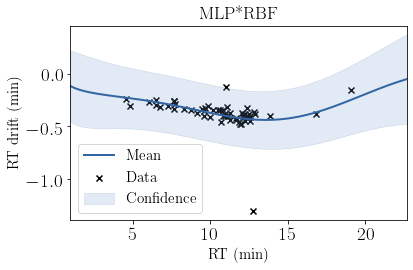

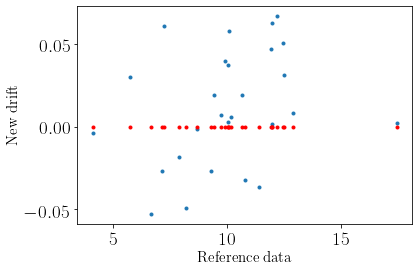

Cross-Predicted Accuracy for MLP*RBF : 0.9998069611388091
Mean absolute error for MLP*RBF : 0.02977552424979648
Mean squared error for MLP*RBF : 0.0013268139407315949
Final kernel: RBF
Optimization restart 1/10, f = -55.739386042798365
Optimization restart 2/10, f = -55.73938604282567
Optimization restart 3/10, f = -55.7393860219315
Optimization restart 4/10, f = -55.73938596197245
Optimization restart 5/10, f = -55.73938604283763
Optimization restart 6/10, f = -55.73938604277741
Optimization restart 7/10, f = -55.739386042722586
Optimization restart 8/10, f = -55.73938604282436
Optimization restart 9/10, f = -55.73938604283094
Optimization restart 10/10, f = -55.73938604274625


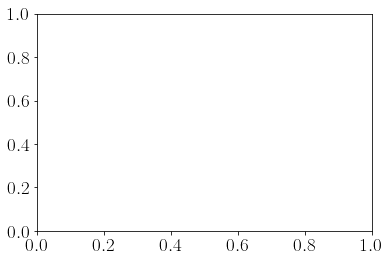

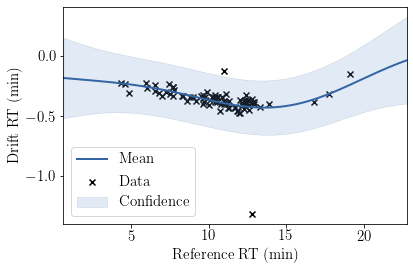


Name : GP regression
Objective : -55.73938604283763
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  rbf.variance             |   0.07455614705953348  |      +ve      |        
  rbf.lengthscale          |     6.842514185139003  |      +ve      |        
  Gaussian_noise.variance  |  0.012635629082679702  |      +ve      |        


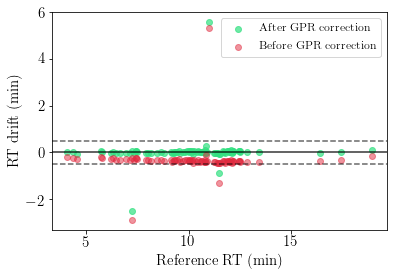

In [18]:
from metab_utils import get_rts_between_datasets
mal_1_rt, mal_1_mz, zik_1_rt, zik_1_mz = get_rts_between_datasets('mal', 'zik', matches)



stratcol = return_stratcol(mal_1_rt, mal_1_mz, zik_1_rt, zik_1_mz, nbins = 4)
output_dir = osp+'positive_mode/mal/2/'
from gpr_utils import get_drift_gpr_model
mmal, accuracy, mae, mse = get_drift_gpr_model(zik_1_rt, mal_1_rt, stratcol, output_dir,zscore = 2, plot = True)

In [18]:
from metab_utils import get_rts_between_datasets
mal_1_rt, mal_1_mz, zik_1_rt, zik_1_mz = get_rts_between_datasets('mal', 'zik', matches)



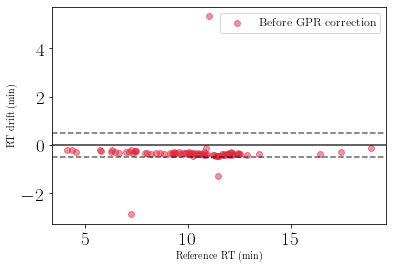

In [25]:
plotdrift(np.array(zik_1_rt),np.array(mal_1_rt),  '/Users/anamaria/Desktop/')

In [18]:
def plotdrift(old_mzml_rts, new_mzml_rts, output_dir):
    fig, ax = plt.subplots()
    nice_fonts = {"text.usetex": True,
        "font.family": "serif",
        "font.serif" : "Times New Roman"}
    plt.rcParams.update(nice_fonts)

    plt.rc('font', family='serif')
    plt.rc('xtick', labelsize=19)
    plt.rc('ytick', labelsize=19)

    #ax.scatter(old_mzml_rts, old_mzml_rts - new_mzml_rts - gpr_predicted_data, alpha = 0.7, color = '#32E081', label = 'After GPR correction' )
    ax.scatter(old_mzml_rts, old_mzml_rts - new_mzml_rts , alpha = 0.5, color = '#E02A3F', label = 'Before GPR correction')


    ax.legend(loc = 'best', fontsize = 12)
    plt.ylabel('RT drift (min)')
    plt.xlabel('Reference RT (min)')
    plt.axhline(y=0, color='#000000', alpha = 0.8, linestyle='solid')
    plt.axhline(y=0.5, color='#000000', alpha = 0.6, linestyle='dashed')
    plt.axhline(y=-0.5, color='#000000', alpha = 0.6, linestyle='dashed')
    
    plt.show()
    fig.savefig(output_dir+'plot.png', format = 'png', dpi =400, bbox_inches='tight')


In [16]:
print(accuracy, mae, mse)

0.9311827449189929 0.1422651019284574 0.46350145790990366


In [54]:
print(accuracy, mae, mse)

0.931182535271675 0.14226259350041215 0.4635028699371244


#### In the end, we are using the RBF kernel for the GP regression.

rbf.,value,constraints,priors
variance,1.1881762921101213,+ve,
lengthscale,0.2927926560501475,+ve,


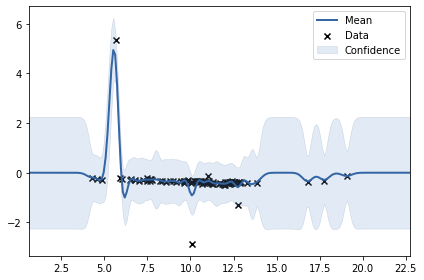

In [19]:
#kmal = kmal
kmal = GPy.kern.RBF(input_dim=1, variance=0.1, lengthscale=0.5)
mmal = GPy.models.GPRegression(np.array(mal_1_rt)[:,None], np.array(zik_1_rt)[:,None] - np.array(mal_1_rt)[:,None],kmal)
#mmal.optimize_restarts(10)
mmal.optimize()
mmal.plot()
plt.ylim()

mmal.parameters[0]

In [47]:
mmal.parameter_names()

'rbf.variance'

In [45]:
mmal.param_array

array([1.18817629, 0.29279266, 0.12977958])

In [50]:
pd.DataFrame([mmal.param_array], columns = mmal.parameter_names())

,rbf.variance,rbf.lengthscale,Gaussian_noise.variance
0,1.188176,0.292793,0.12978


In [55]:
?mmal.

(-4.0, 4.0)

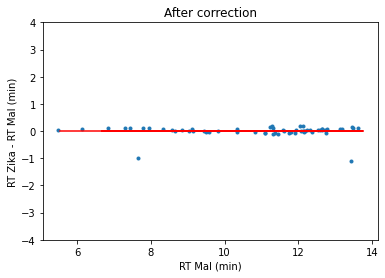

In [30]:
gpr_predicted_data,_ = mmal.predict(np.array(mal_1_rt_mod)[:,None])

plt.plot(np.array(mal_1_rt_mod)[:,None]+gpr_predicted_data, np.array(zik_1_rt_mod)[:,None] - (np.array(mal_1_rt_mod)[:,None]+gpr_predicted_data), '.')
plt.plot(np.array(zik_1_rt_mod)[:,None], np.array(zik_1_rt_mod)[:,None] -np.array(zik_1_rt_mod)[:,None], 'r')
plt.plot()
plt.xlabel('RT Mal (min)')
plt.ylabel('RT Zika - RT Mal (min)')
plt.title('After correction')
plt.ylim(-4,4)

Dumping the model with pickle for future use of the data.

In [13]:
with open('/Users/anamaria/Documents/pymz/mzmine/malmodel.txt', 'wb') as handle:
    pickle.dump(mmal, handle)

In [31]:
with open(osp+'negative_mode/mmal.txt', 'wb') as handle:
    pickle.dump(mmal, handle)

The same workflow will be applied for the analysis of the VL vs Zika RT datsets.

#### Zika RT vs VL RT 

In [7]:
from metab_utils import get_rts_between_datasets
vl_1_rt, zik_1_rt, vl1_zik1_diff = get_rts_between_datasets('vl', 'zik', matches)

ValueError: too many values to unpack (expected 3)

In [10]:
Checking correlation between RT drift and other variables

In [20]:
from metab_utils import get_rts_between_datasets
vl_1_rt, vl_1_mz, zik_1_rt, zik_1_mz = get_rts_between_datasets('vl', 'zik', matches)



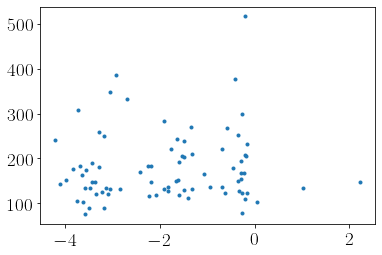

In [21]:
plt.plot(np.subtract(zik_1_rt,vl_1_rt), zik_1_mz, '.')

[2, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 3, 2, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1]
Choosing the optimal kernel
Optimization restart 1/10, f = 32.43943714319033
Optimization restart 2/10, f = 32.43943714318753
Optimization restart 3/10, f = 32.439437143400475
Optimization restart 4/10, f = 32.439437143187334
Optimization restart 5/10, f = 32.4394371433728
Optimization restart 6/10, f = 32.43943715772467
Optimization restart 7/10, f = 32.43943714374822
Optimization restart 8/10, f = 32.4394371436849
Optimization restart 9/10, f = 32.43943715493256
Optimization restart 10/10, f = 32.43943715313837


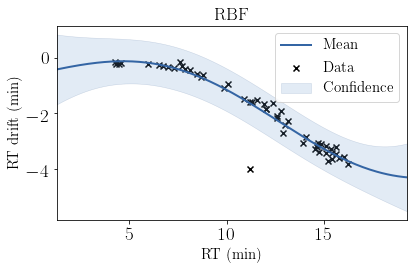

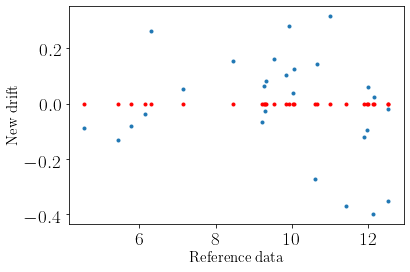

Cross-Predicted Accuracy for RBF : 0.9935746997247444
Mean absolute error for RBF : 0.1452131090038005
Mean squared error for RBF : 0.03394545104106308
Optimization restart 1/10, f = 33.19740934657164
Optimization restart 2/10, f = 33.19740934653251
Optimization restart 3/10, f = 33.19740934653106
Optimization restart 4/10, f = 33.19740934662385
Optimization restart 5/10, f = 33.197409346539196
Optimization restart 6/10, f = 33.19740937694611
Optimization restart 7/10, f = 33.19740934655219
Optimization restart 8/10, f = 33.19740936428646
Optimization restart 9/10, f = 33.19740934654007
Optimization restart 10/10, f = 33.197409346626316


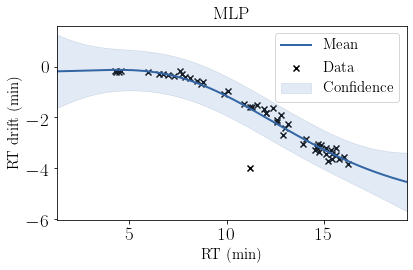

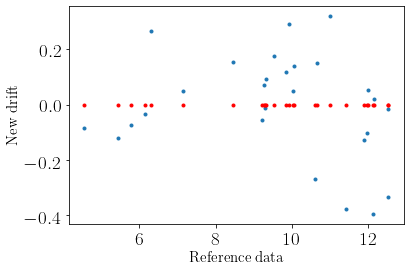

Cross-Predicted Accuracy for MLP : 0.9934551673572829
Mean absolute error for MLP : 0.14658539918612193
Mean squared error for MLP : 0.03457695150853804
Optimization restart 1/10, f = 32.37968386823428
Optimization restart 2/10, f = 32.37963640548571
Optimization restart 3/10, f = 32.379706156617345
Optimization restart 4/10, f = 32.37963617664082
Optimization restart 5/10, f = 32.37963591989006
Optimization restart 6/10, f = 32.37967979641205
Optimization restart 7/10, f = 31.652531175723837
Optimization restart 8/10, f = 32.37965799730629
Optimization restart 9/10, f = 32.379656967192474
Optimization restart 10/10, f = 32.379640319071974


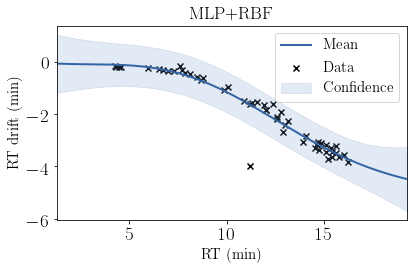

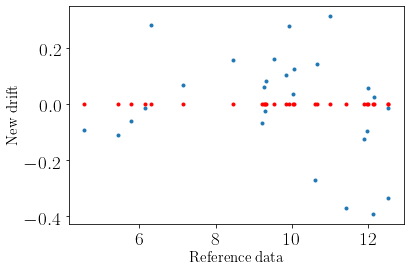

Cross-Predicted Accuracy for MLP+RBF : 0.993607275938619
Mean absolute error for MLP+RBF : 0.14379214325204898
Mean squared error for MLP+RBF : 0.033773347913456826
Optimization restart 1/10, f = 30.583058097069532
Optimization restart 2/10, f = 30.583058854794118
Optimization restart 3/10, f = 30.58304907924035
Optimization restart 4/10, f = 30.583053613777455
Optimization restart 5/10, f = 30.583055845938635
Optimization restart 6/10, f = 30.58304759482639
Optimization restart 7/10, f = 30.58304560599556
Optimization restart 8/10, f = 30.583045160938003
Optimization restart 9/10, f = 30.58304728819138
Optimization restart 10/10, f = 30.58304941047721


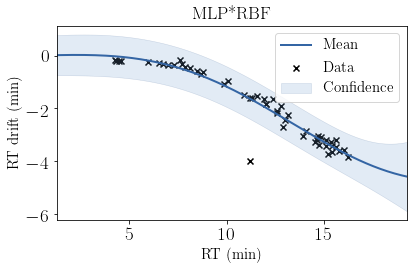

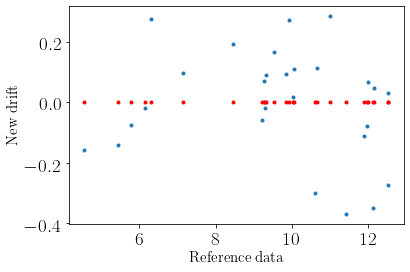

Cross-Predicted Accuracy for MLP*RBF : 0.9939925871776065
Mean absolute error for MLP*RBF : 0.14393107658400653
Mean squared error for MLP*RBF : 0.031737713275649594
Final kernel: MLP+RBF
Optimization restart 1/10, f = 31.921666312720973


 /Users/anamaria/.pyenv/versions/3.8.1/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 2/10, f = 32.52411796637238
Optimization restart 3/10, f = 32.523280975355505
Optimization restart 4/10, f = 32.523250456662325
Optimization restart 5/10, f = 32.52323758312523
Optimization restart 6/10, f = 32.523362255696455
Optimization restart 7/10, f = 32.52324998524321
Optimization restart 8/10, f = 32.5233739780832
Optimization restart 9/10, f = 32.52328886849942
Optimization restart 10/10, f = 32.52316316702714


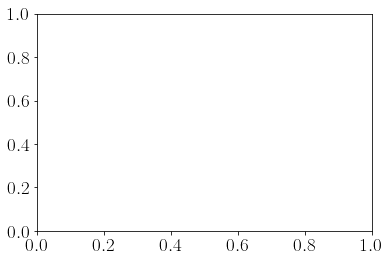

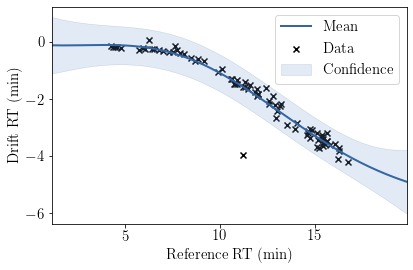


Name : GP regression
Objective : 31.921666312720973
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  sum.mlp.variance         |       431089.8728363894  |      +ve      |        
  sum.mlp.weight_variance  |   1.731256359019959e-07  |      +ve      |        
  sum.mlp.bias_variance    |  5.562684646268137e-309  |      +ve      |        
  sum.rbf.variance         |      1.1981729512212016  |      +ve      |        
  sum.rbf.lengthscale      |       6.426525823525167  |      +ve      |        
  Gaussian_noise.variance  |     0.10389477413592013  |      +ve      |        


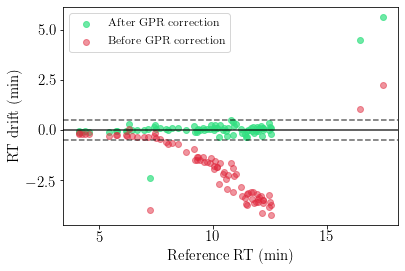

In [34]:
from metab_utils import get_rts_between_datasets
vl_1_rt, vl_1_mz, zik_1_rt, zik_1_mz = get_rts_between_datasets('vl', 'zik', matches)



stratcol = return_stratcol(vl_1_rt, vl_1_mz, zik_1_rt, zik_1_mz, nbins = 3)
output_dir = osp+'positive_mode/vl/2/'
from gpr_utils import get_drift_gpr_model
mmal, accuracy, mae, mse = get_drift_gpr_model(zik_1_rt, vl_1_rt, stratcol, output_dir,zscore = 2, plot = True)

from gpr_utils import get_drift_gpr_model
mvl, accuracy, mae, mse = get_drift_gpr_model(zik_1_rt, vl_1_rt, df['vl_rt_cat'], zscore = 2,plot = True)

In [30]:
print(accuracy, mae, mse)

0.8969424785907788 0.3561233662113452 0.7021410547811143


In [49]:
print(accuracy, mae, mse)

0.891814264017013 0.27158016700820375 0.7370800863115735


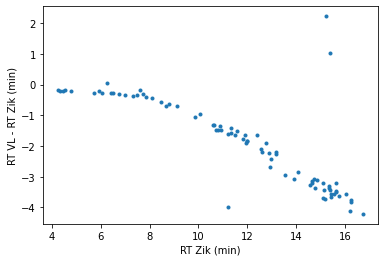

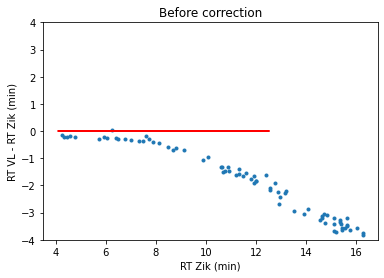

In [33]:
from metab_utils import plot_and_get_values_for_regression
zik_1_rt_mod, vl_1_rt_mod = plot_and_get_values_for_regression(zik_1_rt,'Zik',vl_1_rt,'VL', vl1_zik1_diff, ml = False)

In [34]:
from metab_utils import try_gp_regressions
mvl, kvl, resultsvl = try_gp_regressions(vl_1_rt_mod, zik_1_rt_mod-vl_1_rt_mod)

Cross-Predicted Accuracy for RBF : 0.9744831569929051
Mean absolute error for RBF : 0.16878794006135453
Mean squared error for RBF : 0.04408622713305147
Cross-Predicted Accuracy for MLP : 0.9741897023936249
Mean absolute error for MLP : 0.17058351561472423
Mean squared error for MLP : 0.04459323758546168
Cross-Predicted Accuracy for MLP+RBF : 0.974435015873031
Mean absolute error for MLP+RBF : 0.1690838102914802
Mean squared error for MLP+RBF : 0.044169402012664005
Cross-Predicted Accuracy for MLP*RBF : 0.9744834428491974
Mean absolute error for MLP*RBF : 0.16878607640138563
Mean squared error for MLP*RBF : 0.044085733250425516
Final kernel: MLP*RBF


sum.,value,constraints,priors
rbf.variance,6.649985915014671,+ve,
rbf.lengthscale,9.88211326355211,+ve,
mlp.variance,1.1765642063638595,+ve,
mlp.weight_variance,149304.55090505816,+ve,
mlp.bias_variance,5.562684646268137e-309,+ve,


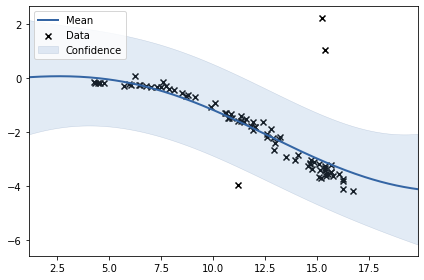

In [38]:
#kvl = GPy.kern.RBF(input_dim=1, variance=0.1, lengthscale=0.5) + GPy.kern.MLP(1)
#mvl = GPy.models.GPRegression(np.array(vl_1_rt)[:,None], np.array(zik_1_rt)[:,None]-np.array(vl_1_rt)[:,None], kvl)

mvl.optimize()
mvl.plot()
mvl.parameters[0]

(-1.0, 1.0)

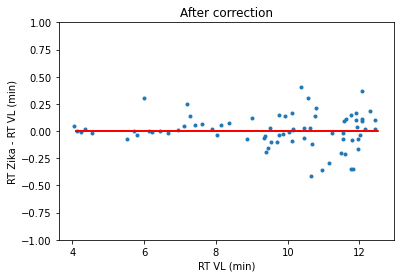

In [18]:
gpr_predicted_data,_ = mvl.predict(np.array(vl_1_rt_mod)[:,None])

plt.plot(np.array(vl_1_rt_mod)[:,None]+gpr_predicted_data, np.array(zik_1_rt_mod)[:,None] - (np.array(vl_1_rt_mod)[:,None]+gpr_predicted_data), '.')
plt.plot(np.array(zik_1_rt_mod)[:,None], np.array(zik_1_rt_mod)[:,None] -np.array(zik_1_rt_mod)[:,None], 'r')
plt.plot()
plt.xlabel('RT VL (min)')
plt.ylabel('RT Zika - RT VL (min)')
plt.title('After correction')
plt.ylim(-1,1)

In [ ]:
with open('/Users/anamaria/Documents/pymz/mzmine/vlmodel.txt', 'wb') as handle:
    pickle.dump(mvl, handle)

In [41]:
with open(osp+'negative_mode/mvl.txt', 'wb') as handle:
    pickle.dump(mvl, handle)

#### Zika RT vs HAT RT 

In [8]:
matches

{'serotonin': {'Mal_Std1_1_20Dec16': (1754,
   177.1023178100586,
   4.0217,
   3782182.2901406214),
  'Hat_Std1_2_20150130': (766,
   177.10223388671875,
   12.525366666666667,
   258932758.81113324),
  'Hat_Std1_1_20150130': (874,
   177.10223388671875,
   12.457600000000001,
   305546767.65958226)},
 'melatonin': {'Mal_Std1_1_20Dec16': (2490,
   233.12831115722656,
   4.3155833333333335,
   33276196048.949608),
  'Mal_Std1_2_20Dec16': (2584,
   233.12832641601562,
   4.302533333333333,
   33772812929.161053),
  'VL_Std1_1_06Mar18': (3230,
   233.1283416748047,
   4.251833333333334,
   25597167515.199986),
  'VL_Std1_2_06Mar18': (2853,
   233.12835693359375,
   4.288749999999999,
   19683997207.912857),
  'Zik_Std1_1_23Oct18': (2668,
   233.12841796875,
   4.091466666666666,
   38876808977.52192),
  'Zik_Std1_2_23Oct18': (2884, 233.1283721923828, 4.0523, 40561910106.74934),
  'Hat_Std1_2_20150130': (1055,
   233.1282958984375,
   5.982183333333333,
   3113367445.117812),
  'Hat_Std1_

In [6]:
from metab_utils import get_rts_between_datasets
hat_1_rt, hat_1_mz, zik_1_rt, zik_1_mz, hat1_zik1_diff = get_rts_between_datasets('hat', 'zik', matches)

In [7]:
import pandas as pd
df = pd.DataFrame([hat_1_rt, hat_1_mz, zik_1_rt, zik_1_mz, hat1_zik1_diff]).transpose()
df.columns = ['HAT rt', 'HAT mz', 'ZIK rt', 'ZIK mz', 'drift']

#check correlations between columns
corr_matrix = df.corr()
corr_matrix['drift'].sort_values(ascending=False)

drift     1.000000
HAT rt    0.510580
ZIK mz    0.058335
HAT mz    0.058335
ZIK rt   -0.163956
Name: drift, dtype: float64

In [ ]:
It seems that HAT rt has the highest correlation with the rt drift between the hat and zik datasets. 
So, we will be stratifying the training sample using hat rt column.
It seems that splitting the data set in a stratified fashion, using hat rt as the class labels would be a good idea

In [78]:
import numpy as np


df['hat_rt_cat'] = pd.cut(df['HAT rt'], 
                          bins=[3., 10., 12., 14, np.inf],
                          labels=[1, 2, 3, 4])

In [79]:
df['hat_rt_cat']

0     1
1     1
2     1
3     3
4     1
     ..
77    1
78    2
79    1
80    3
81    1
Name: hat_rt_cat, Length: 82, dtype: category
Categories (4, int64): [1 < 2 < 3 < 4]

In [9]:
def create_bins_mz_range(dataset, n_bins):
    dataset.sort()
    lowest_value = np.min(dataset)-0.001
    highest_value = np.max(dataset)+0.001
    width = (highest_value - lowest_value)/n_bins
    bins = []
    for i in range(n_bins):
        bins.append((lowest_value+width*i, lowest_value+width*(i+1)))
    nb = [i[0] for i in bins]
    nb.append(bins[-1][1])
    return nb

In [65]:
np.arange(1,5,1)

array([1, 2, 3, 4])

In [63]:
x

range(1, 5)

In [10]:
from metab_utils import get_rts_between_datasets
hat_1_rt, hat_1_mz, zik_1_rt, zik_1_mz = get_rts_between_datasets('hat', 'zik', matches)

def return_stratcol(hat_1_rt, hat_1_mz, zik_1_rt, zik_1_mz, nbins):
    df = pd.DataFrame([hat_1_rt, hat_1_mz, zik_1_rt, zik_1_mz, np.subtract(zik_1_rt, hat_1_rt)]).transpose()
    df.columns = ['HAT rt', 'HAT mz', 'ZIK rt', 'ZIK mz', 'drift']

    #check correlations between columns
    corr_matrix = df.corr()
    corr_matrix['drift'].sort_values(ascending=False)

   
    bins = create_bins_mz_range(list(df['HAT rt']), nbins)
    
    df['hat_rt_cat'] = pd.cut(df['HAT rt'], 
                              bins=bins,
                              labels=np.arange(1,nbins+1,1))
    return df['hat_rt_cat']

stratcol = return_stratcol(hat_1_rt, hat_1_mz, zik_1_rt, zik_1_mz, nbins = 5)

from gpr_utils import get_drift_gpr_model
mhat, accuracy, mae, mse = get_drift_gpr_model(zik_1_rt, hat_1_rt, stratcol, zscore = 2,plot = True)

In [11]:
stratcol = return_stratcol(hat_1_rt, hat_1_mz, zik_1_rt, zik_1_mz, nbins = 5)

[1, 1, 1, 3, 1, 3, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 1, 2, 1, 3, 3, 2, 2, 1, 1, 1, 2, 2, 1, 2, 3, 3, 3, 3, 4, 2, 3, 3, 4, 3, 3, 4, 3, 4, 3, 5, 4, 3, 3, 3, 3, 4, 5, 1, 2, 2, 3, 3, 1]
Choosing the optimal kernel
Optimization restart 1/10, f = 96.19275268253679
Optimization restart 2/10, f = 96.19275268248683
Optimization restart 3/10, f = 96.19275268875558
Optimization restart 4/10, f = 96.19275268347025
Optimization restart 5/10, f = 96.19275268248617
Optimization restart 6/10, f = 96.19275268460854
Optimization restart 7/10, f = 96.19275268251305
Optimization restart 8/10, f = 96.19275268248597
Optimization restart 9/10, f = 96.19275268267151
Optimization restart 10/10, f = 96.19275268249424


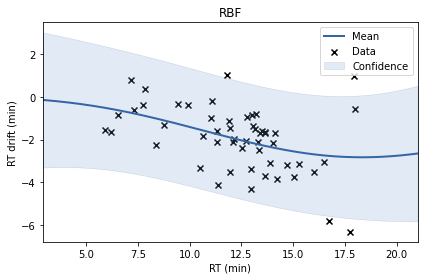

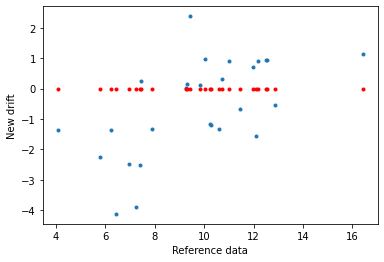

Cross-Predicted Accuracy for RBF : 0.6105772548259089
Mean absolute error for RBF : 1.3138401140167302
Mean squared error for RBF : 2.772443898840589
Optimization restart 1/10, f = 95.12838468721033
Optimization restart 2/10, f = 95.12839069557279
Optimization restart 3/10, f = 95.12841743358337
Optimization restart 4/10, f = 95.1283881170707
Optimization restart 5/10, f = 95.12838694352342
Optimization restart 6/10, f = 95.12838186936816
Optimization restart 7/10, f = 95.12839046550582
Optimization restart 8/10, f = 95.12838510598526
Optimization restart 9/10, f = 95.1283995502784
Optimization restart 10/10, f = 95.12839158806958


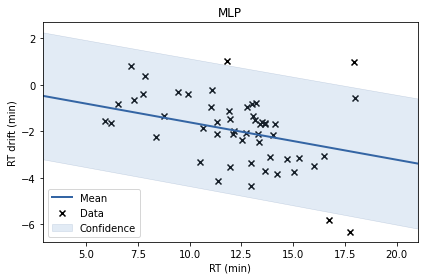

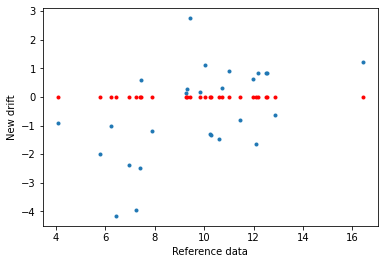

Cross-Predicted Accuracy for MLP : 0.6071599341781981
Mean absolute error for MLP : 1.3267131012693605
Mean squared error for MLP : 2.796773062705664
Optimization restart 1/10, f = 95.1046817071917
Optimization restart 2/10, f = 95.63892923095929
Optimization restart 3/10, f = 95.10464918842997
Optimization restart 4/10, f = 95.10465279695948
Optimization restart 5/10, f = 95.10464949129147
Optimization restart 6/10, f = 94.35653446224056
Optimization restart 7/10, f = 95.59066930318139
Optimization restart 8/10, f = 95.10464105819774
Optimization restart 9/10, f = 95.10467935278984
Optimization restart 10/10, f = 95.10465243583899


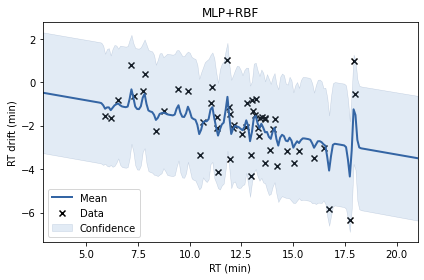

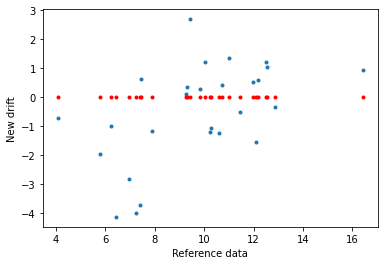

Cross-Predicted Accuracy for MLP+RBF : 0.5665054705722479
Mean absolute error for MLP+RBF : 1.3590483289465936
Mean squared error for MLP+RBF : 3.0862071570972622
Optimization restart 1/10, f = 95.12837660964425
Optimization restart 2/10, f = 95.12837616445456
Optimization restart 3/10, f = 95.12837797356667
Optimization restart 4/10, f = 95.12837776958595
Optimization restart 5/10, f = 95.12837480415996
Optimization restart 6/10, f = 95.12840370526236
Optimization restart 7/10, f = 95.12837883294026
Optimization restart 8/10, f = 95.12838119847055
Optimization restart 9/10, f = 95.12837451197049
Optimization restart 10/10, f = 95.12837351590096


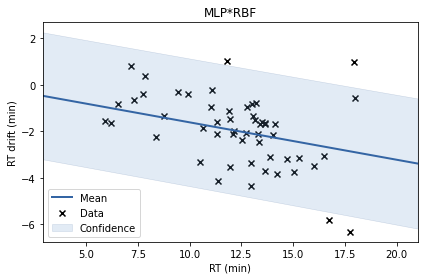

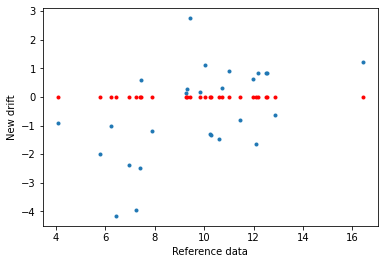

Cross-Predicted Accuracy for MLP*RBF : 0.6071612917171056
Mean absolute error for MLP*RBF : 1.3267120129946504
Mean squared error for MLP*RBF : 2.7967633978863686
Final kernel: RBF
Optimization restart 1/10, f = 148.51777106424578
Optimization restart 2/10, f = 148.5177710642498
Optimization restart 3/10, f = 148.51777106840296
Optimization restart 4/10, f = 148.51777106426195
Optimization restart 5/10, f = 148.51777106472997
Optimization restart 6/10, f = 148.51777106424652
Optimization restart 7/10, f = 148.5177710644656
Optimization restart 8/10, f = 148.51777106424936
Optimization restart 9/10, f = 148.5177710642477
Optimization restart 10/10, f = 148.5177710665246


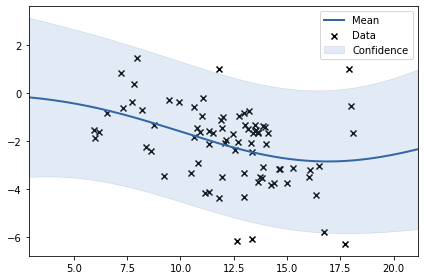


Name : GP regression
Objective : 148.51777106424578
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |              value  |  constraints  |  priors
  rbf.variance             |  3.604041175284921  |      +ve      |        
  rbf.lengthscale          |  8.068417441047925  |      +ve      |        
  Gaussian_noise.variance  |   2.16383860773797  |      +ve      |        


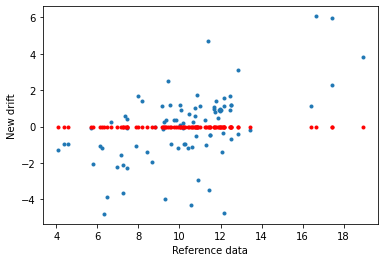

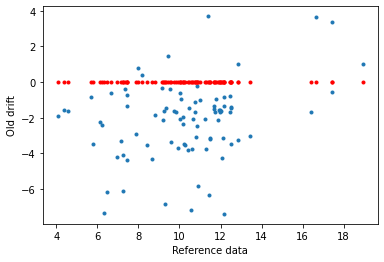

In [12]:
from gpr_utils import get_drift_gpr_model
mhat, accuracy, mae, mse = get_drift_gpr_model(zik_1_rt, hat_1_rt, stratcol, zscore = 2,plot = True)

In [14]:
matches

{'serotonin': {'Mal_Std1_1_20Dec16': (1.0, 177.10236, 4.02, 314135.0),
  'Hat_Std1_2_20150130': (2.0, 177.10223, 12.53, 15993618.0),
  'Hat_Std1_1_20150130': (2.0, 177.10222, 12.46, 18218192.0)},
 'melatonin': {'Mal_Std1_1_20Dec16': (2.0, 233.12828, 4.32, 1729600988.0),
  'Mal_Std1_2_20Dec16': (1.0, 233.12817, 4.3, 1786176528.0),
  'VL_Std1_1_06Mar18': (1.0, 233.1282, 4.25, 1271105472.0),
  'VL_Std1_2_06Mar18': (1.0, 233.12825, 4.29, 1036508880.0),
  'Zik_Std1_1_23Oct18': (1.0, 233.12831, 4.09, 2046167614.0),
  'Zik_Std1_2_23Oct18': (1.0, 233.12837, 4.05, 2130536061.0),
  'Hat_Std1_2_20150130': (3.0, 233.12825, 5.98, 174812747.0),
  'Hat_Std1_1_20150130': (3.0, 233.12825, 5.98, 235811275.0)},
 'phenylhydrazine': {'Mal_Std1_1_20Dec16': (3.0, 109.07604, 4.86, 6144530.0),
  'Mal_Std1_2_20Dec16': (2.0, 109.07597, 4.8, 6329873.0),
  'VL_Std1_1_06Mar18': (2.0, 109.07605, 4.76, 4643862.0),
  'VL_Std1_2_06Mar18': (2.0, 109.07608, 4.77, 2722880.0),
  'Zik_Std1_1_23Oct18': (2.0, 109.07607, 4.55,

In [13]:
print(accuracy, mae, mse)

0.4968836301772228 1.449244258208492 3.9352969718534268


In [56]:
print(accuracy, mae, mse)

0.5755569894862501 1.230353140754316 2.982683986824439


In [90]:
print(accuracy, mae, mse)

0.5818984968557335 1.3106705953976545 2.9381203775417872


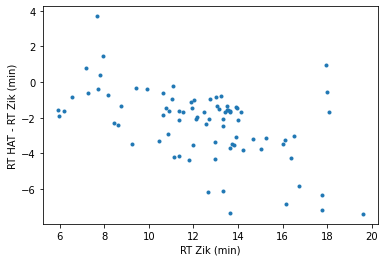

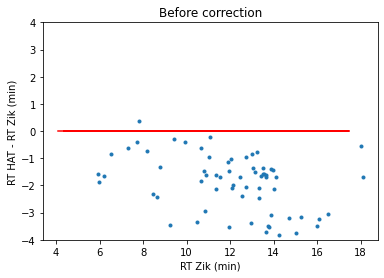

In [7]:
from metab_utils import plot_and_get_values_for_regression
zik_1_rt_mod, hat_1_rt_mod = plot_and_get_values_for_regression(zik_1_rt,'Zik',
                                                                hat_1_rt,'HAT',  hat1_zik1_diff, ml=False)

In [15]:
from metab_utils import try_gp_regressions
mhat, khat, resultshat = try_gp_regressions(hat_1_rt_mod, zik_1_rt_mod-hat_1_rt_mod)

Cross-Predicted Accuracy for RBF : -0.5254488834265056
Mean absolute error for RBF : 0.9055670526996339
Mean squared error for RBF : 1.1829666446563953
Cross-Predicted Accuracy for MLP : -0.5492657535539238
Mean absolute error for MLP : 0.8890249613687671
Mean squared error for MLP : 1.2014363313479368
Cross-Predicted Accuracy for MLP+RBF : -0.5492572555334054
Mean absolute error for MLP+RBF : 0.889025572071989
Mean squared error for MLP+RBF : 1.2014297412386725
Cross-Predicted Accuracy for MLP*RBF : -0.5493131179389106
Mean absolute error for MLP*RBF : 0.8890338298431805
Mean squared error for MLP*RBF : 1.201473061839658
Final kernel: RBF


sum.,value,constraints,priors
Cosine.variance,0.07304756892138273,+ve,
Cosine.lengthscale,0.8254630507041266,+ve,
rbf.variance,3.3946601277425286,+ve,
rbf.lengthscale,10.74770878108617,+ve,


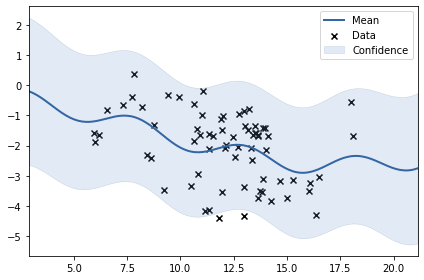

In [21]:
khat = khat
mhat = GPy.models.GPRegression(hat_1_rt_mod[:,None], zik_1_rt_mod[:,None]-hat_1_rt_mod[:,None], khat)

mhat.optimize()
mhat.plot()
mhat.parameters[0]

(-4.0, 4.0)

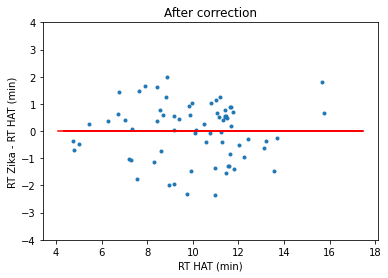

In [22]:
gpr_predicted_data,_ = mhat.predict(np.array(hat_1_rt_mod)[:,None])

plt.plot(np.array(hat_1_rt_mod)[:,None]+gpr_predicted_data, np.array(zik_1_rt_mod)[:,None] - (np.array(hat_1_rt_mod)[:,None]+gpr_predicted_data), '.')
plt.plot(np.array(zik_1_rt_mod)[:,None], np.array(zik_1_rt_mod)[:,None] -np.array(zik_1_rt_mod)[:,None], 'r')
plt.plot()
plt.xlabel('RT HAT (min)')
plt.ylabel('RT Zika - RT HAT (min)')
plt.title('After correction')
plt.ylim(-4,4)

In [92]:
with open(osp+'/pymz/mzmine/hatmodel.txt', 'wb') as handle:
    pickle.dump(mhat, handle)

[1, 1, 1, 1, 3, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, 5, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 3, 3, 3, 3, 4, 2, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 5]
Choosing the optimal kernel
Optimization restart 1/10, f = 73.18018528809426
Optimization restart 2/10, f = 73.18018529461783
Optimization restart 3/10, f = 73.1801852881095
Optimization restart 4/10, f = 73.18018528809934
Optimization restart 5/10, f = 73.18018528809988
Optimization restart 6/10, f = 73.18018528859427
Optimization restart 7/10, f = 73.1801852881557
Optimization restart 8/10, f = 73.18018528814184
Optimization restart 9/10, f = 73.18018528809682
Optimization restart 10/10, f = 73.18018528809463


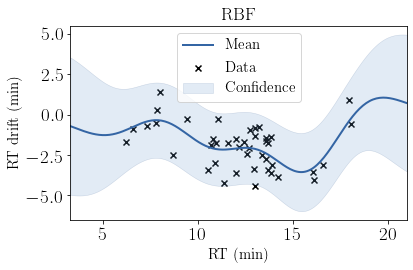

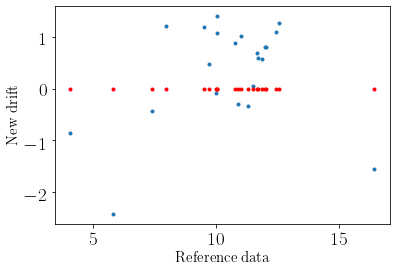

Cross-Predicted Accuracy for RBF : 0.8323231005946202
Mean absolute error for RBF : 0.8742085028101936
Mean squared error for RBF : 1.0411025983254563
Optimization restart 1/10, f = 74.48666147543318
Optimization restart 2/10, f = 74.4866612392417
Optimization restart 3/10, f = 74.4866612542614
Optimization restart 4/10, f = 75.17093614201544
Optimization restart 5/10, f = 74.48666123935908
Optimization restart 6/10, f = 74.4866612490181
Optimization restart 7/10, f = 74.48666123925082
Optimization restart 8/10, f = 74.48666123918488
Optimization restart 9/10, f = 74.48666123918106
Optimization restart 10/10, f = 74.48666124422172


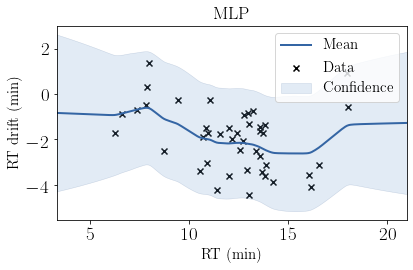

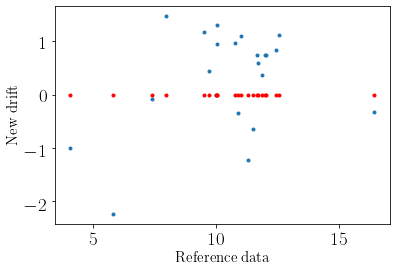

Cross-Predicted Accuracy for MLP : 0.8481076786713269
Mean absolute error for MLP : 0.8381390419745295
Mean squared error for MLP : 0.9430964608825128
Optimization restart 1/10, f = 72.90067814113638
Optimization restart 2/10, f = 72.90072033744565
Optimization restart 3/10, f = 72.90068086551945
Optimization restart 4/10, f = 72.90067627074028
Optimization restart 5/10, f = 72.9007203779194
Optimization restart 6/10, f = 72.90067790093435
Optimization restart 7/10, f = 72.90067819391416
Optimization restart 8/10, f = 72.90067657273524
Optimization restart 9/10, f = 72.90067996288103
Optimization restart 10/10, f = 72.9006995717609


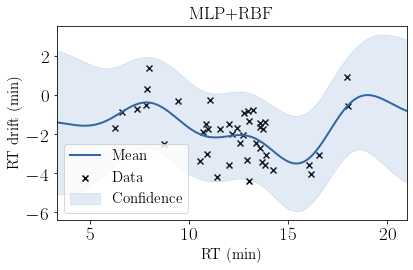

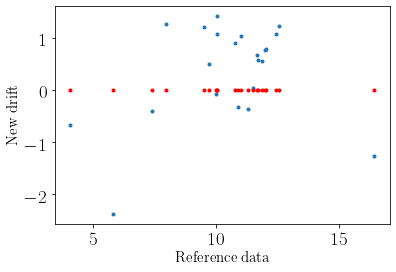

Cross-Predicted Accuracy for MLP+RBF : 0.8407165894510171
Mean absolute error for MLP+RBF : 0.8511878192721644
Mean squared error for MLP+RBF : 0.9889875897082927
Optimization restart 1/10, f = 72.53455270940312
Optimization restart 2/10, f = 72.5345587935658
Optimization restart 3/10, f = 72.53454534970075
Optimization restart 4/10, f = 72.53455511272568
Optimization restart 5/10, f = 72.53454643838649
Optimization restart 6/10, f = 72.5345497073042
Optimization restart 7/10, f = 72.53454842915829
Optimization restart 8/10, f = 72.53455038173543
Optimization restart 9/10, f = 72.53455143098816
Optimization restart 10/10, f = 72.53455333134364


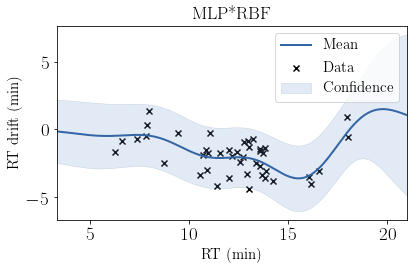

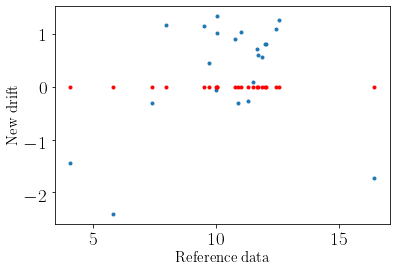

Cross-Predicted Accuracy for MLP*RBF : 0.8251450672104742
Mean absolute error for MLP*RBF : 0.8856019994340425
Mean squared error for MLP*RBF : 1.0856708676195717
Final kernel: MLP


 /Users/anamaria/.pyenv/versions/3.8.1/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 105.74391662776227
Optimization restart 2/10, f = 105.68936211917108
Optimization restart 3/10, f = 105.6893621511296
Optimization restart 4/10, f = 105.68936212313304
Optimization restart 5/10, f = 105.68936211429349
Optimization restart 6/10, f = 106.81377517531794
Optimization restart 7/10, f = 105.68936211507693
Optimization restart 8/10, f = 105.68936211380733
Optimization restart 9/10, f = 105.68936212227479
Optimization restart 10/10, f = 106.81376615439058


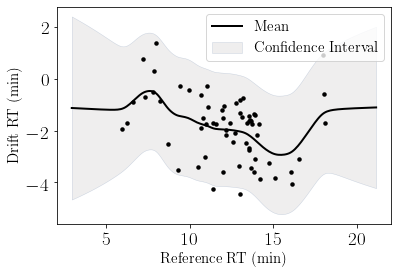


Name : GP regression
Objective : 105.68936211380733
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  mlp.variance             |  12.848789545296812  |      +ve      |        
  mlp.weight_variance      |   16.27327184685993  |      +ve      |        
  mlp.bias_variance        |   9677.633231895781  |      +ve      |        
  Gaussian_noise.variance  |  1.1575810348884827  |      +ve      |        


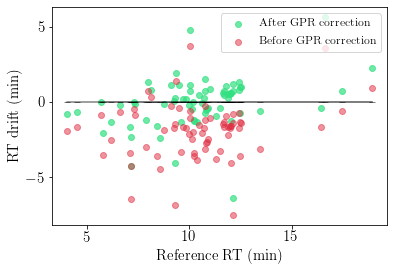

In [34]:
from metab_utils import get_rts_between_datasets
mal_1_rt, mal_1_mz, zik_1_rt, zik_1_mz = get_rts_between_datasets('hat', 'zik', matches, replicate=2)

def return_stratcol(hat_1_rt, hat_1_mz, zik_1_rt, zik_1_mz, nbins):
    df = pd.DataFrame([hat_1_rt, hat_1_mz, zik_1_rt, zik_1_mz, np.subtract(zik_1_rt, hat_1_rt)]).transpose()
    df.columns = ['HAT rt', 'HAT mz', 'ZIK rt', 'ZIK mz', 'drift']

    #check correlations between columns
    corr_matrix = df.corr()
    corr_matrix['drift'].sort_values(ascending=False)

   
    bins = create_bins_mz_range(list(df['HAT rt']), nbins)
    
    df['hat_rt_cat'] = pd.cut(df['HAT rt'], 
                              bins=bins,
                              labels=np.arange(1,nbins+1,1))
    return df['hat_rt_cat']

stratcol = return_stratcol(mal_1_rt, mal_1_mz, zik_1_rt, zik_1_mz, nbins = 5)
output_dir = osp+'positive_mode/hat/'
from gpr_utils import get_drift_gpr_model
mmal, accuracy, mae, mse = get_drift_gpr_model(zik_1_rt, mal_1_rt, stratcol, output_dir,zscore = 2, plot = True)

Choosing the optimal kernel
Optimization restart 1/10, f = 80.89509708841379
Optimization restart 2/10, f = 80.89509708849965
Optimization restart 3/10, f = 80.89509708842269
Optimization restart 4/10, f = 79.47575817007271
Optimization restart 5/10, f = 80.89509708883742
Optimization restart 6/10, f = 80.89509708891767
Optimization restart 7/10, f = 80.89509709045922
Optimization restart 8/10, f = 80.89509708842624
Optimization restart 9/10, f = 80.89509708841348
Optimization restart 10/10, f = 80.89509708861819


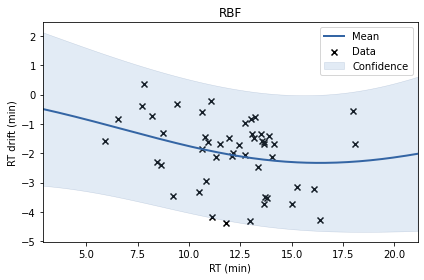

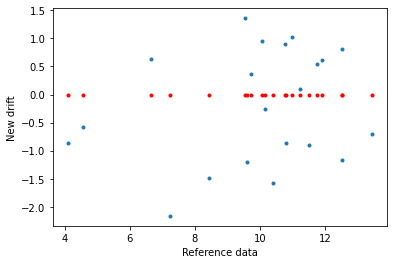

Cross-Predicted Accuracy for RBF : 0.8233856864502562
Mean absolute error for RBF : 0.9072149781309606
Mean squared error for RBF : 1.0402358228180102
Optimization restart 1/10, f = 78.46114773181614
Optimization restart 2/10, f = 78.46114441509172
Optimization restart 3/10, f = 78.46114501634113
Optimization restart 4/10, f = 78.4611715947442
Optimization restart 5/10, f = 78.4611495381372
Optimization restart 6/10, f = 78.46114442030728
Optimization restart 7/10, f = 78.46115109981741
Optimization restart 8/10, f = 78.46119753230907
Optimization restart 9/10, f = 78.46114460688905
Optimization restart 10/10, f = 78.46114466123848


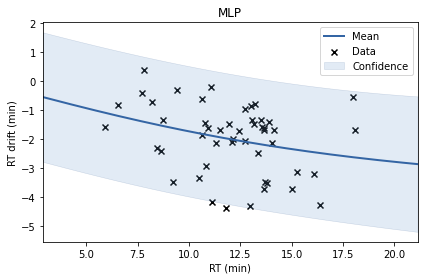

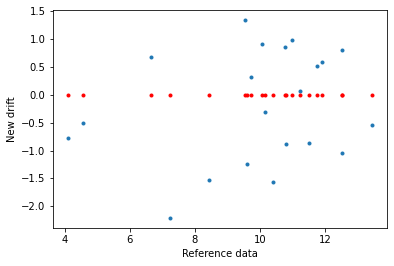

Cross-Predicted Accuracy for MLP : 0.8284230166414789
Mean absolute error for MLP : 0.8823072109532885
Mean squared error for MLP : 1.010566589272018
Optimization restart 1/10, f = 78.46115651670534
Optimization restart 2/10, f = 78.46114452626465
Optimization restart 3/10, f = 78.46114485325288
Optimization restart 4/10, f = 78.4611590604713
Optimization restart 5/10, f = 78.46118627415768
Optimization restart 6/10, f = 78.46114482958563
Optimization restart 7/10, f = 78.46114458760417
Optimization restart 8/10, f = 78.46114442340975
Optimization restart 9/10, f = 78.4611446928859
Optimization restart 10/10, f = 78.4611444551917


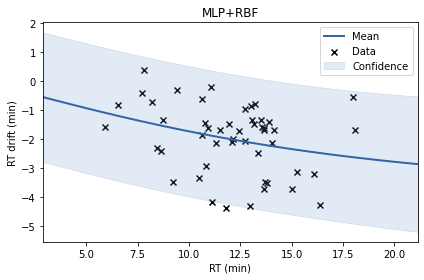

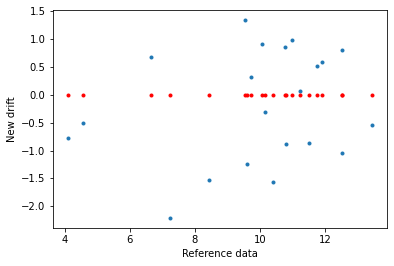

Cross-Predicted Accuracy for MLP+RBF : 0.8284235813892622
Mean absolute error for MLP+RBF : 0.8823054036517538
Mean squared error for MLP+RBF : 1.01056326297947
Optimization restart 1/10, f = 80.26873348781047
Optimization restart 2/10, f = 80.26870940253428
Optimization restart 3/10, f = 80.26871321426485
Optimization restart 4/10, f = 80.26874524717554
Optimization restart 5/10, f = 78.77116761394336
Optimization restart 6/10, f = 80.26872014064071
Optimization restart 7/10, f = 80.26871824067717
Optimization restart 8/10, f = 78.46116373565245
Optimization restart 9/10, f = 78.77116441799242
Optimization restart 10/10, f = 80.26871533388076


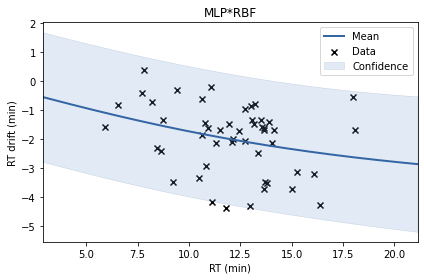

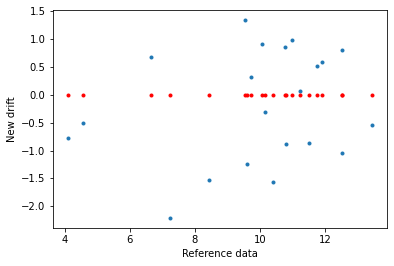

Cross-Predicted Accuracy for MLP*RBF : 0.8284202094318642
Mean absolute error for MLP*RBF : 0.8823147548534526
Mean squared error for MLP*RBF : 1.0105831233792746
Final kernel: MLP+RBF
  sum.                 |                  value  |  constraints  |  priors
  mlp.variance         |     22.283493916670803  |      +ve      |        
  mlp.weight_variance  |    0.00232592789329198  |      +ve      |        
  mlp.bias_variance    |   5.15199027672721e-10  |      +ve      |        
  rbf.variance         |  8.708269803401565e-10  |      +ve      |        
  rbf.lengthscale      |  0.0014136598278775348  |      +ve      |        


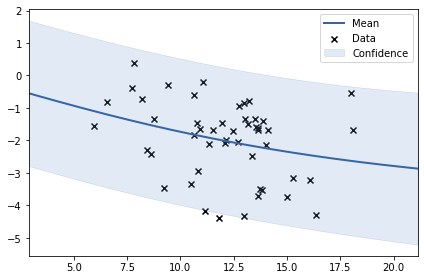

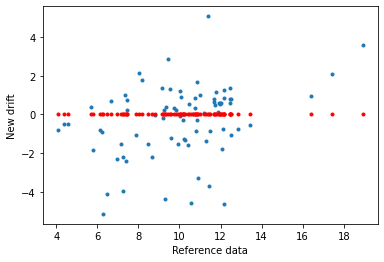

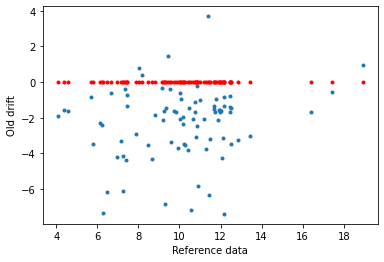

In [87]:
from gpr_utils import get_drift_gpr_model
mhat, accuracy, mae, mse = get_drift_gpr_model(zik_1_rt, hat_1_rt, df['hat_rt_cat'], zscore = 1.5,plot = True)

In [75]:
len(df['hat_rt_cat'])

82

In [9]:
print(accuracy, mae, mse)

0.8178358805750698 0.9092355371388966 1.166329038504568


In [83]:
print(accuracy, mae, mse)

0.45461850159769224 1.3677344134544975 3.8325537744770672


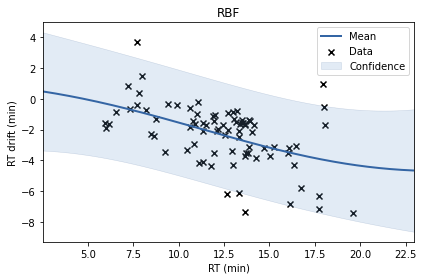

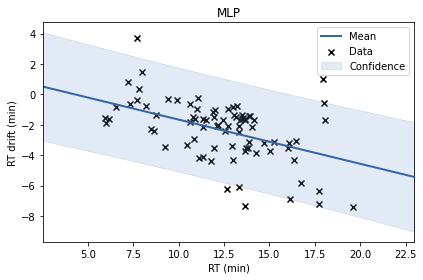

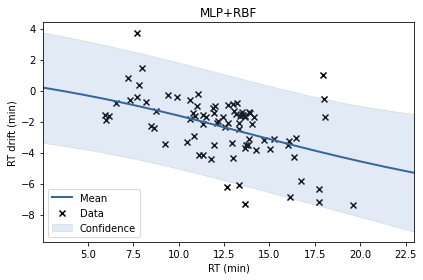

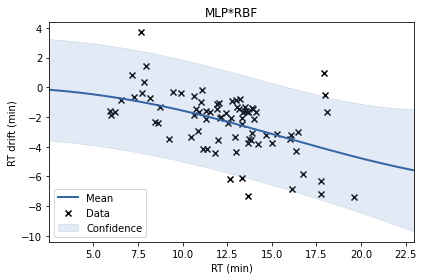

Final kernel: RBF


(<GPy.models.gp_regression.GPRegression at 0x121252400>,
 <GPy.kern.src.rbf.RBF at 0x12153ad60>)

In [21]:
from gpr_utils import try_gp_regressions_with_all_data
try_gp_regressions_with_all_data(hat_1_rt, np.subtract(zik_1_rt,hat_1_rt), plot = True)

### Binning based on m/z data

In [26]:
from metab_utils import plot_gpr_bins_mz_range
from metab_utils import plot_gpr_bins_same_width

Bin: 0 
m/z range: (76.03929138183594, 137.85718994140626)
  rbf.         |                value  |  constraints  |  priors
  variance     |  0.10924062340234678  |      +ve      |        
  lengthscale  |   23.559339614344193  |      +ve      |        
Bin: 1 
m/z range: (137.85718994140626, 199.67508850097656)
  rbf.         |                value  |  constraints  |  priors
  variance     |  0.06774246486507138  |      +ve      |        
  lengthscale  |     7.79574824792595  |      +ve      |        
Bin: 2 
m/z range: (199.67508850097656, 261.49298706054685)
  rbf.         |                value  |  constraints  |  priors
  variance     |  0.14320494930388594  |      +ve      |        
  lengthscale  |   21.037790271030378  |      +ve      |        
Bin: 3 
m/z range: (261.49298706054685, 323.3108856201172)
  rbf.         |                value  |  constraints  |  priors
  variance     |  0.08736176862385243  |      +ve      |        
  lengthscale  |    1386.118589014714  |      +

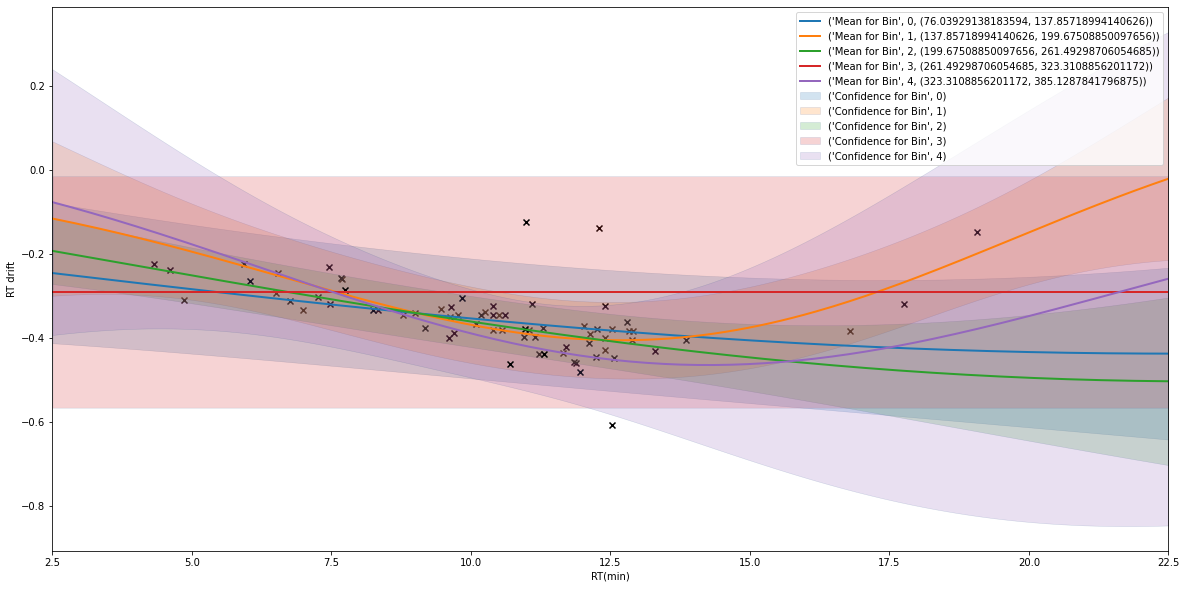

In [44]:
plot_gpr_bins_mz_range(5, 'mal', 'zik', matches, False, 0.5)

Bin: 0 
m/z range: 76.03929138183594 , 123.05532836914062
  rbf.         |                value  |  constraints  |  priors
  variance     |  0.12013803354272005  |      +ve      |        
  lengthscale  |     665.760367800072  |      +ve      |        
Bin: 1 
m/z range: 124.03933715820312 , 134.0447769165039
  rbf.         |                value  |  constraints  |  priors
  variance     |  0.12826006757953887  |      +ve      |        
  lengthscale  |    652.7076668605157  |      +ve      |        
Bin: 2 
m/z range: 136.04273986816406 , 167.03872680664062
  rbf.         |                value  |  constraints  |  priors
  variance     |  0.06977105746874958  |      +ve      |        
  lengthscale  |    8.837883756386539  |      +ve      |        
Bin: 3 
m/z range: 168.06561279296875 , 206.06683349609375
  rbf.         |                value  |  constraints  |  priors
  variance     |  0.05598436345280817  |      +ve      |        
  lengthscale  |    6.799061526045808  |      +ve  

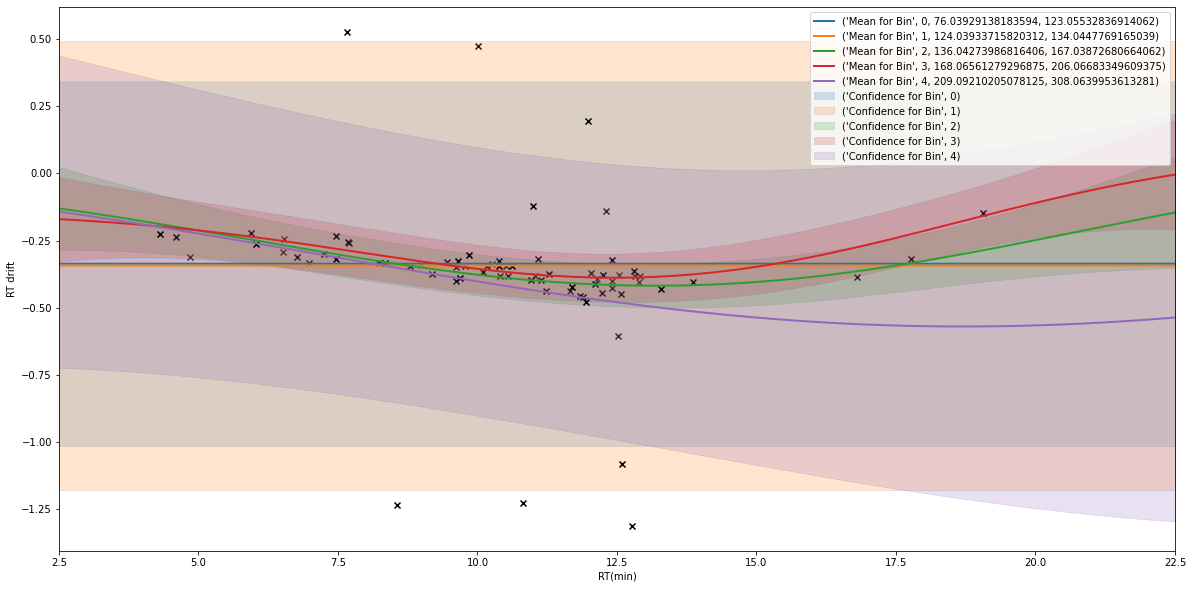

In [45]:
plot_gpr_bins_same_width(5, 'mal', 'zik', matches, False, 1.4)

Bin: 0 
m/z range: 76.03929138183594 , 120.0655746459961
  rbf.         |               value  |  constraints  |  priors
  variance     |  10.212597206727503  |      +ve      |        
  lengthscale  |   9.717449777941974  |      +ve      |        
Bin: 1 
m/z range: 123.05521392822266 , 136.042724609375
  rbf.         |               value  |  constraints  |  priors
  variance     |   8.552531710697101  |      +ve      |        
  lengthscale  |  10.108411986067559  |      +ve      |        
Bin: 2 
m/z range: 136.0618133544922 , 175.10779571533203
  rbf.         |               value  |  constraints  |  priors
  variance     |  10.704416491823642  |      +ve      |        
  lengthscale  |   7.718824080148981  |      +ve      |        
Bin: 3 
m/z range: 176.1029510498047 , 209.09214782714844
  rbf.         |               value  |  constraints  |  priors
  variance     |  13.140208507189504  |      +ve      |        
  lengthscale  |   10.46837339759746  |      +ve      |        
Bi

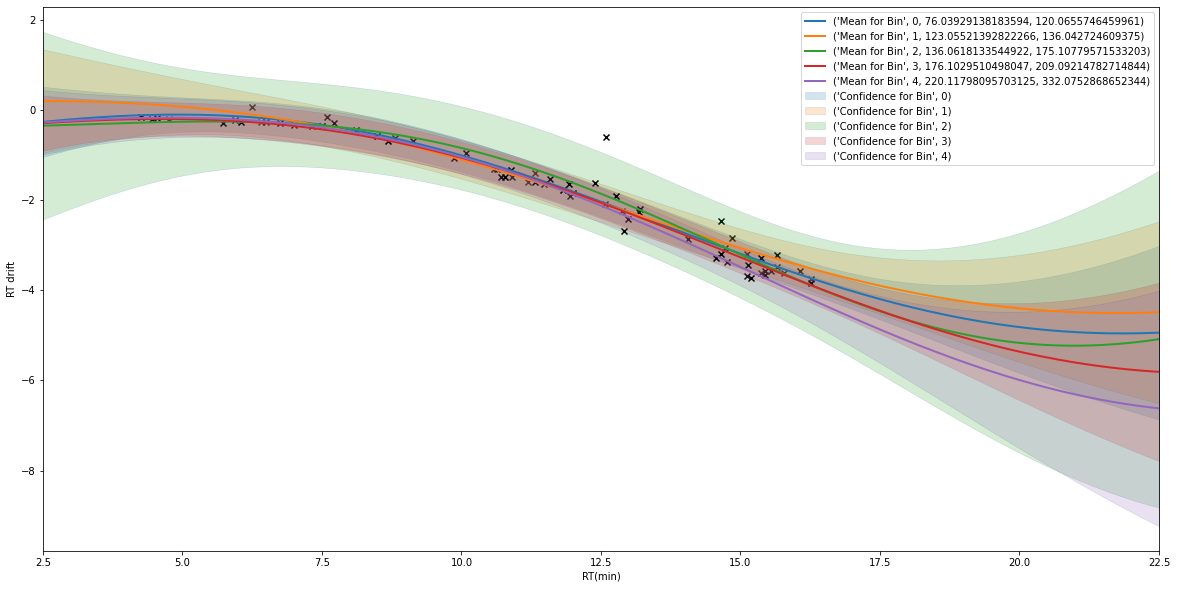

In [46]:
plot_gpr_bins_same_width(5, 'vl', 'zik', matches, False, 1.4)